In [ ]:
import pandas as pd
import numpy as np
import re
import nltk 
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import string, unicodedata
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
import html
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
#from sklearn import neighbors
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Data Cleaning

In [ ]:
#data preprocessing
def text_cleaning(text):
    
    #remove URL
    clean_text = re.sub(r'(http|https|pic.)\S+', " ", text)
    
    #remove retweet notation: RT
    clean_text = re.compile('\#').sub('', re.compile('RT @').sub('@', clean_text).strip())
    
    #convert html characters to unicode
    clean_text = html.unescape(clean_text)
    
    #remove non-letter characters
    clean_text = re.sub('[^A-Za-z ]+', "", clean_text).lower()
    
    #split strings into a list of words
    clean_word = word_tokenize(clean_text)
    
    #lemmatize
    lem = WordNetLemmatizer()
    
    #remove stop words
    #a word is considered to be a stop word based on the nltk package
    stop_words = set(stopwords.words('english'))
    words = set([lem.lemmatize(word) for word in clean_word if not word in stop_words])
    result_text = ' '.join(words)
    
    return result_text

### Load sentiment_analysis.csv, and apply text_cleaning function:

In [ ]:
sentiment_df = pd.read_csv("sentiment_analysis.csv")
sentiment_df_clean = sentiment_df.copy()

In [ ]:
sentiment_df_clean["text"] = sentiment_df_clean["text"].apply(text_cleaning)

In [ ]:
#check cleaning result
sentiment_df_clean["text"][3]

'thanks ladiesecproud custodial wall newly painted great million summer davidgaibis painter job'

### Load US_elections_2020.csv, and apply text_cleaning2 and text_cleaning functions:

In [ ]:
#data processing to address the leading letter 'b' in the election df
def text_cleaning2(text):
    
    #remove the leading letter 'b'
    result_text = text.lstrip("b")
    
    return result_text

In [ ]:
election_df = pd.read_csv("US_Elections_2020.csv")
election_df_clean = election_df.copy()

In [ ]:
#remove line breaks
election_df_clean["text"] = election_df_clean["text"].replace(r'\s+|\\n', ' ', regex=True) 

In [ ]:
election_df_clean["text"] = election_df_clean["text"].apply(text_cleaning2)
election_df_clean["text"] = election_df_clean["text"].apply(text_cleaning)

In [ ]:
#check cleaning result
election_df_clean["text"][3]

'dying think trumpvirus every success american joebiden donaldtrump second'

# Exploratory analysis

### Determine political party of tweets

In [ ]:
def word_freq(df, k):   
    #function returns top k frequent words in given df
    
    counter = Counter()
    tokenizer = RegexpTokenizer(r'\w+')
    lem = WordNetLemmatizer() 
    stemer = nltk.stem.porter.PorterStemmer()

    for r in range(df.shape[0]):
        tweet = df['text'][r]
        stop_words = set(stopwords.words('english'))
        words = [i for i in tokenizer.tokenize(tweet) if i not in stop_words and len(i)>2]
        counter.update(words)
        topk = counter.most_common(k)
        
    return topk

In [ ]:
#gives the top 80 most frequent words in election_df_clean
word_freq(election_df_clean, 80)

[('trump', 425),
 ('covid', 392),
 ('bidenharris', 316),
 ('realdonaldtrump', 311),
 ('joebiden', 235),
 ('vote', 233),
 ('biden', 199),
 ('election', 164),
 ('people', 130),
 ('maga', 129),
 ('get', 107),
 ('american', 99),
 ('day', 99),
 ('like', 97),
 ('coronavirus', 96),
 ('one', 84),
 ('new', 82),
 ('make', 78),
 ('death', 76),
 ('president', 74),
 ('america', 74),
 ('case', 73),
 ('gop', 72),
 ('democrat', 66),
 ('say', 65),
 ('today', 63),
 ('need', 62),
 ('time', 61),
 ('know', 61),
 ('year', 61),
 ('joe', 61),
 ('want', 58),
 ('trumpcrimefamily', 58),
 ('voting', 56),
 ('voted', 56),
 ('would', 54),
 ('dont', 51),
 ('think', 49),
 ('lie', 48),
 ('republican', 46),
 ('ballot', 45),
 ('win', 44),
 ('donald', 44),
 ('voter', 42),
 ('said', 41),
 ('back', 41),
 ('see', 41),
 ('lockdown', 40),
 ('week', 40),
 ('country', 40),
 ('rally', 39),
 ('going', 39),
 ('every', 38),
 ('watch', 38),
 ('last', 38),
 ('life', 37),
 ('kag', 37),
 ('please', 37),
 ('great', 37),
 ('right', 36),
 

From the above list, we can see that the words that indicate political affiliations are: 'trump', 'bidenharris', 'realdonaldtrump', 'joebiden', 'biden', 'democrat', 'trumpcrimefamily', 'republican', 'donald', 'kamalaharris'.

In order to determine the political party of a given tweet in US_elections_2020.csv without knowing other information. Based on the result of top 80 frequent words, decision has been made that a tweet belongs to: 

(i) Republican Party, if the tweet content contains 'trump', 'republican', 'donald', and sentiment is positive (=1), and does not contain 'biden', 'joe', 'democrat', 'harris'. Or, the tweet content contains 'biden', 'joe', 'democrat', 'harris', and sentiment is negative (=0), and does not contain 'trump', 'republican', 'donald'.

(ii) Democratic Party, if the tweet content contains 'biden', 'joe', 'democrat', 'harris', and sentiment is positive (=1), and does not contain  'trump', 'republican', 'donald'. Or, the tweet content contains 'trump', 'republican', 'donald', and sentiment is negative (=0) , and does not contain 'biden', 'joe', 'democrat', 'harris'.

(iii) everything else will be catagorized as 'Others'.

In [ ]:
election_df_clean.shape

(2552, 3)

In [ ]:
republican1 = election_df_clean[election_df_clean['text'].str.contains('trump | republican | donald')]
republican1 = republican1[~republican1.text.str.contains('biden | joe | democrat | harris')]
republican1 = republican1.loc[republican1['sentiment'] == 1]

republican2 = election_df_clean[election_df_clean['text'].str.contains('biden | joe | democrat | harris')]
republican2 = republican2[~republican2.text.str.contains('trump | republican | donald')]
republican2 = republican2.loc[republican2['sentiment'] == 0]

In [ ]:
republican = republican1.append(republican2)
republican

,text,sentiment,negative_reason
30,realdonaldtrump felon national deputy campaign...,1,NaN
36,trump weeser get position whitehouse kid ask e...,1,NaN
47,trump dm leadright lancaster maga join kag las...,1,NaN
63,realdonaldtrump bidenharris end,1,NaN
72,people realdonaldtrump twelve every testing to...,1,NaN
...,...,...,...
2422,china trap joebiden trapped would escape help ...,0,covid19
2434,blowing hit joebiden fucker tax mutha horn sto...,0,crime
2448,joebiden jerk,0,corruption
2469,done joebiden thing loser never freaking ameri...,0,corruption


In [ ]:
democratic1 = election_df_clean[election_df_clean['text'].str.contains('biden | joe | democrat | harris')]
democratic1 = democratic1[~democratic1.text.str.contains('trump | republican | donald')]
democratic1 = democratic1.loc[democratic1['sentiment'] == 1]

democratic2 = election_df_clean[election_df_clean['text'].str.contains('trump | republican | donald')]
democratic2 = democratic2[~democratic2.text.str.contains('biden | joe | democrat | harris')]
democratic2 = democratic2.loc[democratic2['sentiment'] == 0]

In [ ]:
democratic = democratic1.append(democratic2)
democratic

,text,sentiment,negative_reason
15,hour chat hippie happened dethippiechicks chic...,1,NaN
24,totally china politician joebiden corrupt comp...,1,NaN
28,speaks joebiden gibberish frontier love,1,NaN
34,people maga blacklivesmatter american joebiden...,1,NaN
37,even kelliekelly though accurate big air antib...,1,NaN
...,...,...,...
2513,badge w sick republican honor watching getting...,0,covid19
2532,next fake news trump red thinking country poll...,0,corruption
2534,realdonaldtrump economy dream case worst ameri...,0,corruption
2539,trump hold due front small rally crowd minneso...,0,discrimination


In [ ]:
party_list = list(republican.index) + list(democratic.index)
other_party = list(set(election_df_clean.index) - set(party_list))

political_other = election_df_clean.iloc[other_party]

In [ ]:
political_other

,text,sentiment,negative_reason
0,even nov bidenharris damage month dec afraid j...,0,covid19
1,sueck lord promote recovery launch initiative ...,0,others
3,dying think trumpvirus every success american ...,1,NaN
4,diversityandinclusion make must u citizen vote...,1,NaN
5,accelerating killed trumpvirus rising american,0,discrimination
...,...,...,...
2545,one loved anyone die who superspreaderinchief ...,1,NaN
2546,mitchsnyder trump votered movement maga magala...,1,NaN
2547,legal one impeached removal call citizen offic...,1,NaN
2548,county bidenharris nowthisnews montgomery deli...,1,NaN


The results indicate that there are approximately 419 republican tweets, 537 democratic tweets, and 1596 tweets that belong to 'political_other'. The majority of the tweets do not show an obvious affiliation, and the distributions of the political affiliations between Republican and Democratic are a bit imbalanced.

### Visualization

Plot the histograms of tweet lengths split by the sentiment value for sentiment_df_clean & election_df_clean:

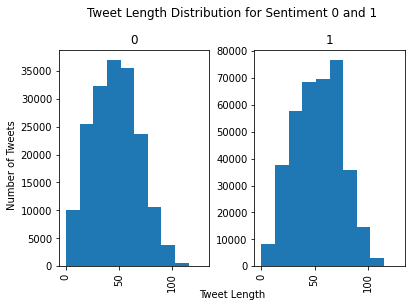

In [ ]:
sentiment_df_clean['length'] = sentiment_df_clean['text'].apply(len)

fig, axes = plt.subplots(nrows=1, ncols=2)
sentiment_df_clean.hist('length',by='label', figsize=(12, 10), ax=axes)

plt.suptitle('Tweet Length Distribution for Sentiment 0 and 1', x=0.5, y=1.05)
fig.text(0.5, 0.04, 'Tweet Length', ha='center')
fig.text(-0.02, 0.5, 'Number of Tweets', va='center', rotation='vertical')
plt.show()

In sentiment_df_clean, the distribution of lengths for both positive and negative sentiments are similar, right-skewed. Majority of both positive and negative are short.

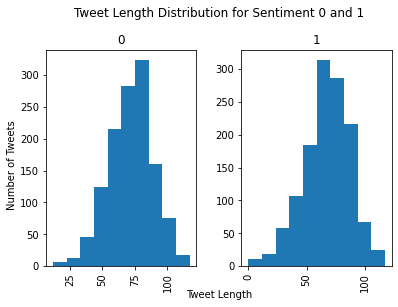

In [ ]:
election_df_clean['length'] = election_df_clean['text'].apply(len)

fig, axes = plt.subplots(nrows=1, ncols=2)
election_df_clean.hist('length',by='sentiment', figsize=(12, 10), ax=axes)

plt.suptitle('Tweet Length Distribution for Sentiment 0 and 1', x=0.5, y=1.05)
fig.text(0.5, 0.04, 'Tweet Length', ha='center')
fig.text(0.01, 0.5, 'Number of Tweets', va='center', rotation='vertical')
plt.show()

In election_df_clean, the distribution of lengths for both positive and negative sentimenta are very close to normal distribution. 

# Model Preparation and Implementation on General Tweets

In [ ]:
#transform text to vectors 
#limit number of features to 300 to avoid excessively long running time
#since the general tweets dataset sample size is already very large
def text_processing(text, is_tfidf):
    vectorizer = TfidfVectorizer(stop_words = 'english', 
                                 use_idf = is_tfidf, 
                                 max_features = 300, 
                                 ngram_range = (1,1)).fit(text)
    return vectorizer

### Bag of Words (BoW)

In [ ]:
vectorizer = text_processing(sentiment_df_clean['text'], False) #Bag of Words
text_rep = vectorizer.transform(sentiment_df_clean['text'])

#replace text data with their vector representations
X_tf = pd.DataFrame(data = text_rep.toarray(), columns = vectorizer.get_feature_names())
y = sentiment_df_clean.label
X_tf.head()

,actually,aint,amazing,america,art,award,away,awesome,babe,baby,bad,bc,bday,beautiful,believe,best,better,big,birthday,bitch,black,bless,blessed,book,boy,brother,business,car,care,cat,cause,chance,check,child,christmas,class,come,coming,congrats,congratulation,...,trump,try,trying,tweet,twitter,ugly,ur,use,video,view,visit,vote,wait,wan,want,watch,way,week,weekend,welcome,white,win,winner,winter,wish,woman,wonderful,wont,word,work,world,worst,wow,wrong,ya,yall,year,yes,young,youre
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.707107,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.707107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#separate data into training and test
X_train, X_test, y_train, y_test = train_test_split(text_rep, y, test_size=0.3, random_state=42)

In [ ]:
X_train.shape

(385273, 300)

In [ ]:
#logistic regression

#set max_iter (386000) to be greater than number of training data (=385273)
clf_lr = LogisticRegression(random_state=0, max_iter=386000).fit(X_train, y_train)
test_accuracy_lr = accuracy_score(y_test, clf_lr.predict(X_test))
test_accuracy_lr

0.8989328843614869

In [ ]:
#Naive Bayes

clf_nb = GaussianNB().fit(X_train.toarray(), y_train)
y_pred = clf_nb.predict(X_test.toarray())
test_accuracy_nb = metrics.accuracy_score(y_test,y_pred)
test_accuracy_nb

0.8498164948703352

In [ ]:
#decision tree

clf_dt = DecisionTreeClassifier().fit(X_train,y_train)
y_pred = clf_dt.predict(X_test)
test_accuracy_dt = metrics.accuracy_score(y_test,y_pred)
test_accuracy_dt

0.9001623081674923

In [ ]:
#random forest

clf_rf = RandomForestClassifier(n_estimators=100).fit(X_train,y_train)
y_pred = clf_rf.predict(X_test)
test_accuracy_rf = metrics.accuracy_score(y_test,y_pred)
test_accuracy_rf

0.9054857738102448

In [ ]:
#kNN

#initial number of neighbors is the sqrt(number of training data)
clf_knn = KNeighborsClassifier(n_neighbors= 620, p=2, metric='euclidean').fit(X_train,y_train)
y_pred = clf_knn.predict(X_test)
test_accuracy_knn = metrics.accuracy_score(y_test,y_pred)
test_accuracy_knn

0.8426095277316829

In [ ]:
#SVM

clf_svm = SVC(max_iter=386000).fit(X_train,y_train)
y_pred = clf_svm.predict(X_test)
test_accuracy_svm = accuracy_score(y_test, y_pred)
test_accuracy_svm

0.9069998425368524

In [ ]:
#XGBoost

clf_xgb = XGBClassifier().fit(X_train,y_train)
y_pred = clf_xgb.predict(X_test)
test_accuracy_xgb = accuracy_score(y_test,y_pred)
test_accuracy_xgb

0.8532564590171877

### TF-IDF

In [ ]:
vectorizer = text_processing(sentiment_df_clean['text'], True) #TF-IDF
text_rep = vectorizer.transform(sentiment_df_clean['text'])

#replace text data with their vector representations
X_tf = pd.DataFrame(data = text_rep.toarray(), columns = vectorizer.get_feature_names())
y = sentiment_df_clean.label
X_tf.head()

,actually,aint,amazing,america,art,award,away,awesome,babe,baby,bad,bc,bday,beautiful,believe,best,better,big,birthday,bitch,black,bless,blessed,book,boy,brother,business,car,care,cat,cause,chance,check,child,christmas,class,come,coming,congrats,congratulation,...,trump,try,trying,tweet,twitter,ugly,ur,use,video,view,visit,vote,wait,wan,want,watch,way,week,weekend,welcome,white,win,winner,winter,wish,woman,wonderful,wont,word,work,world,worst,wow,wrong,ya,yall,year,yes,young,youre
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.752613,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.658463,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#separate data into training and test
X_train, X_test, y_train, y_test = train_test_split(text_rep, y, test_size=0.3, random_state=42)
X_train.shape

(385273, 300)

In [ ]:
#logistic regression

#set max_iter (386000) to be greater than number of training data (=385273)
clf_lr = LogisticRegression(random_state=0, max_iter=386000).fit(X_train, y_train)
test_accuracy_lr = accuracy_score(y_test, clf_lr.predict(X_test))
test_accuracy_lr

0.8989631657360191

In [ ]:
#Naive Bayes

clf_nb = GaussianNB().fit(X_train.toarray(), y_train)
y_pred = clf_nb.predict(X_test.toarray())
test_accuracy_nb = metrics.accuracy_score(y_test,y_pred)
test_accuracy_nb

0.8427609346043435

In [ ]:
#decision tree

clf_dt = DecisionTreeClassifier().fit(X_train,y_train)
y_pred = clf_dt.predict(X_test)
test_accuracy_dt = metrics.accuracy_score(y_test,y_pred)
test_accuracy_dt

0.898018386850616

In [ ]:
#random forest

clf_rf = RandomForestClassifier(n_estimators=100).fit(X_train,y_train)
y_pred = clf_rf.predict(X_test)
test_accuracy_rf = metrics.accuracy_score(y_test,y_pred)
test_accuracy_rf

0.9052798604634261

In [ ]:
#XGBoost

clf_xgb = XGBClassifier().fit(X_train,y_train)
y_pred = clf_xgb.predict(X_test)
test_accuracy_xgb = accuracy_score(y_test,y_pred)
test_accuracy_xgb

0.8511064814254049

In [ ]:
#kNN

#initial number of neighbors should be the sqrt(number of training data)
clf_knn = KNeighborsClassifier(n_neighbors= 620, p=2, metric='euclidean').fit(X_train,y_train)
y_pred = clf_knn.predict(X_test)
test_accuracy_knn = metrics.accuracy_score(y_test,y_pred)
test_accuracy_knn

0.8206918688453106

In [ ]:
#SVM

clf_svm = SVC(max_iter=386000).fit(X_train,y_train)
y_pred = clf_svm.predict(X_test)
test_accuracy_svm = accuracy_score(y_test, y_pred)
test_accuracy_svm

0.9069574486125074

Since all models for Bow and TF-IDF have achieved high accuracies so far, and tuning is optional for this part. Decision has been made to not perform hyperparameter tuning or cross-validation by this stage to save time.

# Model Implementation and Tuning on 2020 US Election Data

The model that gives the best performance (highest accuracy score) is SVM. For both BoW and TF-IDF, the accurcy score is approximately 0.907. Next, we'll implement the SVM model on the 2020 US elections data.

In [ ]:
vectorizer = text_processing(election_df_clean['text'], True) #TF-IDF
text_rep = vectorizer.transform(election_df_clean['text'])

#replace text data with their vector representations
X_tf = pd.DataFrame(data = text_rep.toarray(), columns = vectorizer.get_feature_names())
y = election_df_clean.sentiment
X_tf

,accelerating,ad,america,american,away,bad,ballot,believe,best,better,biden,bidenharris,bidenharristosaveamerica,black,blm,bluewave,book,brettfavre,business,campaign,candidate,care,case,cast,cause,change,china,cleavonmd,close,cnn,come,control,conversation,coronavirus,corrupt,corruption,count,country,county,course,...,usa,using,video,virus,vote,voteblue,voted,voteearly,votehimout,voter,voting,wait,want,war,watch,watching,way,week,white,win,wisconsin,woman,wonder,wont,word,work,worker,working,world,worried,worse,worst,wrong,year,yes,yesterday,young,youre,youtube,zero
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.336344,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.570389,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.303099,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.352458,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2547,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2548,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.346961,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.675885,0.0,...,0.0,0.0,0.0,0.0,0.381092,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2549,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2550,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.268998,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.476309,0.0,0.0,0.0,0.0,0

In [ ]:
#Evaluate the model with best performance on the 2020 US elections data
clf_svm = SVC(max_iter=2600).fit(X_tf,y)
y_pred = clf_svm.predict(X_tf)
test_accuracy_svm = accuracy_score(y, y_pred)
test_accuracy_svm

0.890282131661442

An accuracy of 89.028% indicates that the predictions match the sentiment labelled in the 2020 US elections data well. Though there are still some space for improvement.

In [ ]:
repub_index = republican.index
democ_index = democratic.index

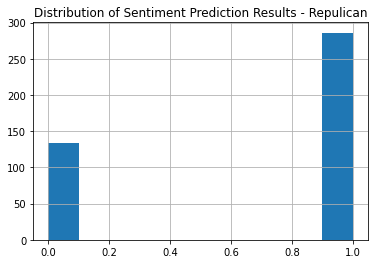

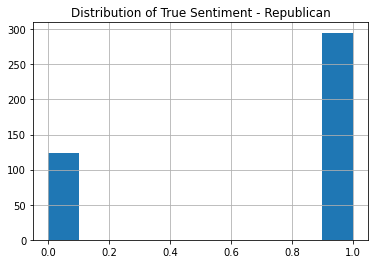

In [ ]:
#visualization of sentiment prediction results and the true sentiment for republican party

df_pred = X_tf.copy()
df_pred['y_pred'] = y_pred
df_pred.iloc[repub_index, :].hist('y_pred')
plt.title('Distribution of Sentiment Prediction Results - Repulican')

df_true = X_tf.copy()
df_true['y_true'] = y
df_true.iloc[repub_index, :].hist('y_true')
plt.title('Distribution of True Sentiment - Republican')

plt.show()

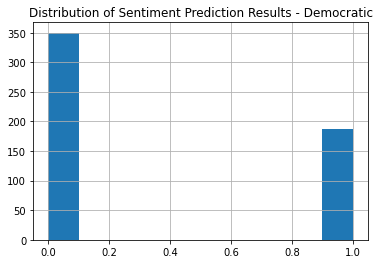

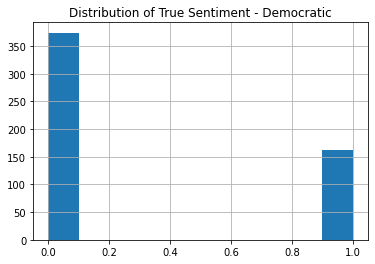

In [ ]:
#visualization of sentiment prediction results and the true sentiment for democratic party

df_pred = X_tf.copy()
df_pred['y_pred'] = y_pred
df_pred.iloc[democ_index, :].hist('y_pred')
plt.title('Distribution of Sentiment Prediction Results - Democratic')

df_true = X_tf.copy()
df_true['y_true'] = y
df_true.iloc[democ_index, :].hist('y_true')
plt.title('Distribution of True Sentiment - Democratic')

plt.show()

The distribution plots of predicted sentiment results for both Republican and Democratic parties match their true sentiment well. Therefore,  NLP analytics based on tweets is somewhat useful for political parties during election campaigns. However, if a human being take at look at the true sentiment labels, some of them do not make sense. For example, a tweet that is labelled with positive sentiment should actually be negative, and vice versa. This means that the prediction accuracy is not very reliable. NLP analysis could be utilized as an informative reference, but one should use it with caution and has his/her own judgement. Based on the sentiment values, there are more positive tweets than the negative tweets of the Republican party in the public eye; and more negative tweets than the positive tweets of the Democratic party in the public eye.

### Implement 3 Models to Predict Negative Reasons of 2020 US Elections Data

In [ ]:
#prepare negative 2020 US elections tweets df for splitting into train and test data
election_df_negative = election_df_clean.loc[election_df_clean['sentiment'] == 0].drop('length', axis = 1)
election_df_negative = election_df_negative.drop('sentiment', axis = 1)

In [ ]:
election_df_negative

,text,negative_reason
0,even nov bidenharris damage month dec afraid j...,covid19
1,sueck lord promote recovery launch initiative ...,others
2,brazil uber advisor said walidphares sanction ...,covid19
5,accelerating killed trumpvirus rising american,discrimination
6,benghazi dead realdonaldtrump one time america...,discrimination
...,...,...
2542,rioter news rather hate air brainwashing watch...,crime
2543,challenged say dini year faultlines racism ahm...,discrimination
2544,maga every year dump votethemout ty resist day...,covid19
2549,jr lied fox said death number nothing almost c...,covid19


In [ ]:
election_df_negative.iloc[40:44,0:2]

,text,negative_reason
74,heartless also fake moscowmitch u report chris...,covid19
78,obscene something say get immorality man immor...,corruption
79,heartless also fake moscowmitch report christi...,covid19
80,dead atrupar infected million tanking stock ma...,corruption


In [ ]:
#print a few texts to see the the given negative_reason makes sense 
print(election_df_negative["text"][74])
print(election_df_negative["text"][78])
print(election_df_negative["text"][79])
print(election_df_negative["text"][80])

heartless also fake moscowmitch u report christian wolf et senategop bad r devout al
obscene something say get immorality man immoral voting
heartless also fake moscowmitch report christian wolfblitzer et devout bad lrreal al
dead atrupar infected million tanking stock market covid lie counting


In [ ]:
#5 different negative reasons labelled in the dataset
election_df_negative['negative_reason'].unique()

array(['covid19', 'others', 'discrimination', 'corruption', 'crime'],
      dtype=object)

In [ ]:
election_df_negative.negative_reason.value_counts()

covid19           405
crime             222
corruption        220
discrimination    215
others            202
Name: negative_reason, dtype: int64

In [ ]:
#Label Encoding 'negative_reason'
negreason_encode = {'others': 0,
    'covid19': 1,
    'discrimination': 2, 
    'corruption': 3,
    'crime': 4}

In [ ]:
df_encode = election_df_negative[['negative_reason']]
df_encode.loc[:,'negative_reason_encoded'] = df_encode.loc[:,'negative_reason'].map(negreason_encode)
df_encode.loc[:,'negative_reason_encoded']=df_encode.loc[:,'negative_reason_encoded'].astype(int)

#5 different negative reasons labelled in the dataset -- encoded
df_encode['negative_reason_encoded'].unique()

array([1, 0, 2, 3, 4])

In [ ]:
#transform text to vectors 
def text_processing(text, is_tfidf):
    vectorizer = TfidfVectorizer(stop_words = 'english', 
                                 use_idf = is_tfidf, 
                                 max_features = 5000, 
                                 ngram_range = (1,1)).fit(text)
    return vectorizer

In [ ]:
vectorizer = text_processing(election_df_negative['text'], True) #TF-IDF
text_rep = vectorizer.transform(election_df_negative['text'])

#replace text data with their vector representations
X_tf = pd.DataFrame(data = text_rep.toarray(), columns = vectorizer.get_feature_names())
y_df = df_encode.drop('negative_reason', axis = 1)
y = y_df.to_numpy()

In [ ]:
#separate data into training and test
#X = text_rep
X_train, X_test, y_train, y_test = train_test_split(text_rep, y, test_size=0.3, random_state=42)

In [ ]:
X_test.shape, y_test.shape

((380, 4112), (380, 1))

In [ ]:
#training data
X_train = pd.DataFrame(data = X_train.toarray(), columns = list(X_tf.columns))
y_train = pd.DataFrame(data = y_train, columns = list(y_df.columns))

### Model 1 - Logistic regression and hyperparameter tuning

In [ ]:
#logistic regression
#grid search for hyperparameter tuning

from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits = 10, shuffle = True)
solver = ["newton-cg", "lbfgs", "liblinear", "sag"]
C = [0.0001,0.001,0.01,0.1,0.5,1,5]

param_grid = {"C": C, "solver": solver}

model_lr = LogisticRegression(multi_class = "ovr")
grid_lr = GridSearchCV(estimator = model_lr, param_grid = param_grid, cv = cv)
grid_lr.fit(X_train, y_train)

print("Tuned Logistic Regression parameters: {}".format(grid_lr.best_params_))
print("Best score is {}%".format(grid_lr.best_score_*100))

Tuned Logistic Regression parameters: {'C': 1, 'solver': 'newton-cg'}
Best score is 35.63457609805924%


### Model 2 - Decision tree and hyperparameter tuning

In [ ]:
#decision tree
#random search for hyperparameter tuning

param_dist = {"max_depth": [2500, None],
              "max_features": randint(1, 5000),
              "min_samples_leaf": randint(1, 100),
              "criterion": ["gini", "entropy"]}

tree = DecisionTreeClassifier()

tree_cv = RandomizedSearchCV(tree, param_dist, cv=10)

tree_cv.fit(X_train,y_train)

print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}%".format(tree_cv.best_score_*100))

Tuned Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 736, 'min_samples_leaf': 44}
Best score is 33.825331971399386%


### Model 3 - SVM and hyperparameter tuning

In [ ]:
#SVM
#grid search for hyperparameter tuning

from sklearn.multiclass import OneVsRestClassifier
cv = StratifiedKFold(n_splits = 10, shuffle = True)

model_svm = OneVsRestClassifier(SVC(kernel="poly"))

parameters = {
    "estimator__C": [0.1,1,10,100],
    "estimator__kernel": ["poly","rbf"],
    "estimator__degree":[1,0.1,0.01,0.001],
}

grid_svm = GridSearchCV(model_svm, param_grid = parameters, cv = cv)

grid_svm.fit(X_train,y_train)

print("Tuned SVM Parameters: {}".format(grid_svm.best_params_))
print("Best score is {}%".format(grid_svm.best_score_*100))

Tuned SVM Parameters: {'estimator__C': 0.1, 'estimator__degree': 1, 'estimator__kernel': 'rbf'}
Best score is 37.32252298263535%


The best scores yielded from the hyperparameter tuning process for the above 3 models are: logistic regression: 35.6 %, decision tree: 33.8 %, and SVM: 37.3 %. SVM has the highest score, therefore, it will be chosen to be implemented on the test data as follows:



In [ ]:
grid_predictions = grid_svm.predict(X_test.toarray())
test_accuracy_svm_grid = accuracy_score(y_test,grid_predictions)
print("Test accuracy by using SVM model is {}%".format(test_accuracy_svm_grid*100))

Test accuracy by using SVM model is 36.05263157894737%


In [ ]:
X_test.shape

(380, 4112)